# Credit Scoring Competition
## Прогнозирование вероятности дефолта заемщика
Link on competition: https://www.kaggle.com/c/sf-dst-scoring/leaderboard#score  
My personal score on Kaggle: roc_auc=0.73778

In [51]:
from pandas import Series
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score


from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures



import warnings
warnings.filterwarnings('ignore')

In [52]:
# Чтобы pandas отображал все столбцы
pd.set_option('display.max_columns', None)

In [53]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv


In [54]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [55]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## Чтение данных 

In [56]:
PATH = '/kaggle/input/sf-dst-scoring/'

df_train = pd.read_csv(PATH + 'train.csv', parse_dates=['app_date'])
df_test = pd.read_csv(PATH + 'test.csv', parse_dates=['app_date'])
sample_submission = pd.read_csv(PATH + 'sample_submission.csv')

print ("формат обучающей выборки:", df_train.shape)
print ("формат тестовой выборки:", df_test.shape)
print ("формат submission:", sample_submission.shape)

формат обучающей выборки: (73799, 19)
формат тестовой выборки: (36349, 18)
формат submission: (24354, 2)


## Посмотрим на колличественные характеристики данных 

In [57]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         73799 non-null  int64         
 1   app_date          73799 non-null  datetime64[ns]
 2   education         73492 non-null  object        
 3   sex               73799 non-null  object        
 4   age               73799 non-null  int64         
 5   car               73799 non-null  object        
 6   car_type          73799 non-null  object        
 7   decline_app_cnt   73799 non-null  int64         
 8   good_work         73799 non-null  int64         
 9   score_bki         73799 non-null  float64       
 10  bki_request_cnt   73799 non-null  int64         
 11  region_rating     73799 non-null  int64         
 12  home_address      73799 non-null  int64         
 13  work_address      73799 non-null  int64         
 14  income            7379

In [58]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         36349 non-null  int64         
 1   app_date          36349 non-null  datetime64[ns]
 2   education         36178 non-null  object        
 3   sex               36349 non-null  object        
 4   age               36349 non-null  int64         
 5   car               36349 non-null  object        
 6   car_type          36349 non-null  object        
 7   decline_app_cnt   36349 non-null  int64         
 8   good_work         36349 non-null  int64         
 9   score_bki         36349 non-null  float64       
 10  bki_request_cnt   36349 non-null  int64         
 11  region_rating     36349 non-null  int64         
 12  home_address      36349 non-null  int64         
 13  work_address      36349 non-null  int64         
 14  income            3634

In [59]:
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


### Объединим имеющиеся выборки train и test для корректной обработки признаков. 

In [60]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # синтетическое значение целевой перменной в тестовой части выборки

data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  datetime64[ns]
 2   education         109670 non-null  object        
 3   sex               110148 non-null  object        
 4   age               110148 non-null  int64         
 5   car               110148 non-null  object        
 6   car_type          110148 non-null  object        
 7   decline_app_cnt   110148 non-null  int64         
 8   good_work         110148 non-null  int64         
 9   score_bki         110148 non-null  float64       
 10  bki_request_cnt   110148 non-null  int64         
 11  region_rating     110148 non-null  int64         
 12  home_address      110148 non-null  int64         
 13  work_address      110148 non-null  int64         
 14  inco

Описания полей датасета:

- **client_id** - идентификатор клиента
- **education** - уровень образования
  - SCH (школа)
  - UGR (кандидат в бакалавры)
  - GRD (бакалавр)
  - PGR (магистр)
  - ACD (академик)  
- **sex** - пол заемщика
- **age** - возраст заемщика
- **car** - флаг наличия автомобиля
- **car_type** - флаг автомобиля иномарки
- **decline_app_cnt** - количество отказанных прошлых заявок
- **good_work** - флаг наличия “хорошей” работы
- **bki_request_cnt** - количество запросов в БКИ
- **home_address** - категоризатор домашнего адреса
- **work_address** - категоризатор рабочего адреса
- **income** - доход заемщика
- **foreign_passport** - наличие загранпаспорта
- **sna** - связь заемщика с клиентами банка
- **first_time** - давность наличия информации о заемщике
- **score_bki** - скоринговый балл по данным из БКИ
- **region_rating** - рейтинг региона
- **app_date** - дата подачи заявки
- **default** - флаг дефолта по кредиту

## EDA или первичное исследование данных

In [62]:
# Посмотрим на данные
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
62070,80746,2014-03-28,SCH,F,56,N,N,0,0,-2.616964,2,50,2,3,20000,1,4,N,1,0
70313,84563,2014-04-01,GRD,M,52,Y,Y,0,0,-1.678531,4,50,1,3,150000,1,3,Y,1,0
3801,26857,2014-02-03,SCH,M,37,N,N,0,0,-2.091091,2,60,2,3,35000,4,3,N,0,0
93200,32684,2014-02-08,UGR,F,25,N,N,0,1,-1.775263,1,60,1,2,8500,1,3,N,1,0
55284,5793,2014-01-13,SCH,M,61,N,N,0,0,-1.859337,0,50,1,3,8500,1,3,N,1,0


In [63]:
# Посмотрим на уникальность данных
data.nunique()

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

### Распределение целевой переменной default

В кол-ном выражении:


0    64427
1     9372
Name: default, dtype: int64

В процентном соотношении:


0    0.873006
1    0.126994
Name: default, dtype: float64

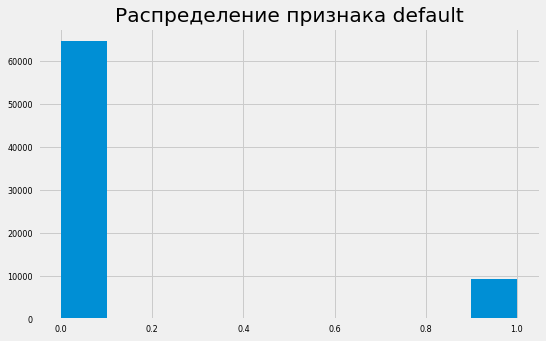

In [64]:
print('В кол-ном выражении:')
display(df_train.default.value_counts())

print('В процентном соотношении:')
display(df_train.default.value_counts(normalize=True))

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [8,5]

plt.hist(df_train.default)
plt.title('Распределение признака default')
plt.show()


Значение **1** признака **default** означает проблемы любого рода с возвратом, **0** - отсутствие проблем. Как видно, в основном заемщики не имеют проблем с возвратом, доля проблемных заемщиков около примерно 12.5%.  

Таким образом классы несбалансированы и это стоит учитывать при построении модели.

### Обработка пропусков 

In [65]:
# Посмотрим на кол-во пропусков данных
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

Перед заполнение пропусков создадим булевый признак, показывающий являтся ли значение в признаке education реальным или замещенным.


In [66]:
data['education_isNAN'] = pd.isna(data['education']).astype('uint8')

In [67]:
# Заменим пропуски в признаке education самым высокочастотным значением
top_edu = data.education.describe().top

data.education = data.education.fillna(value=top_edu)

Text(0.5, 1.0, 'Распределение education')

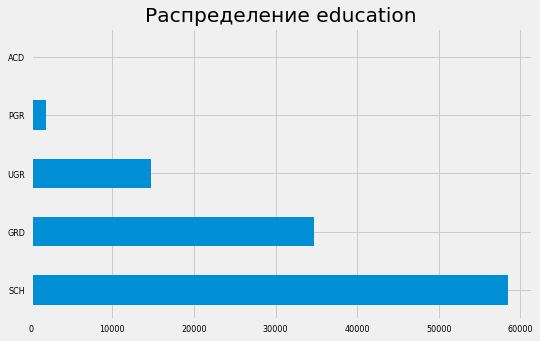

In [68]:
# Посмотрим на признак ближе
data.education.value_counts().plot.barh()
plt.title('Распределение education')

In [69]:
# временные переменные
time_cols = ['app_date']

# бинарные переменные
bin_cols = 'sex car car_type good_work foreign_passport'.split()

# категориальные переменные
cat_cols = 'education region_rating home_address work_address sna first_time'.split()

# числовые переменные
num_cols = 'age decline_app_cnt score_bki bki_request_cnt income'.split()

 ### Проверим числовые данные на выбросы 

In [70]:
def get_stat_metrics(s):
    """
    Функция получает объект типа pandas.Series
    Расчитывает основные статистики:
    median - медиана
    perc25, perc75 - нижний и верхний квартили
    IQR - межквартильный размах
    bottom_border - нижняя граница
    upper_border - верхняя граница
    Возвращает словарь статистических значений.
    """
    q1 = s.quantile(0.25)
    q2 = s.median()
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    minimum = s.min()
    maximum = s.max()
    
    names = 'q1 q2 q3 iqr fence_low fence_high minimum maximum'.split(' ')
    
    stats = dict(zip(names,
                     [q1, q2, q3, iqr, fence_low, \
                      fence_high, minimum, maximum]))
    
    return stats


# Зададим функцию для вывода на экран стат метрик по признаку
def show_stat_data(s):
    """
    Выводит на экран в удобочитаемом виде
    статистические данные.
    Уведомляет о наличии выбросов.
    Рисует гистрограмму распределения признака.
    В случае наличия выбросов, рисует дополнительную
    гистрамму без выбросов.
    """
    
    sd = get_stat_metrics(s) # sd - statistics data
    print(f'[ Признак {s.name} ]')
    print(f"25-й перцентиль: {sd['q1']}, медиана: {sd['q2']},", \
          f"75-й перцентиль: {sd['q3']},", f"IQR: {sd['iqr']}.")
    print(f"Границы выбросов: [{sd['fence_low']}, {sd['fence_high']}]")
    print(f"Диапазон значений: [{sd['minimum']}, {sd['maximum']}]")
    
    if (sd['minimum']<sd['fence_low']) or (sd['maximum']>sd['fence_high']):
        print(f"В данных имеются выбросы!")
        count_under_fence_low = (s < sd['fence_low']).sum()
        count_upper_fence_high = (s > sd['fence_high']).sum()
        print(f"Кол-во выбросов:")
        print(f"За пределами нижней границы: {count_under_fence_low}")
        print(f"За пределами верхней границы: {count_upper_fence_high}\n")
    else:
        print(f"Выбросов нет\n")

In [71]:
for col in num_cols:
    show_stat_data(data[col])

[ Признак age ]
25-й перцентиль: 30.0, медиана: 37.0, 75-й перцентиль: 48.0, IQR: 18.0.
Границы выбросов: [3.0, 75.0]
Диапазон значений: [21, 72]
Выбросов нет

[ Признак decline_app_cnt ]
25-й перцентиль: 0.0, медиана: 0.0, 75-й перцентиль: 0.0, IQR: 0.0.
Границы выбросов: [0.0, 0.0]
Диапазон значений: [0, 33]
В данных имеются выбросы!
Кол-во выбросов:
За пределами нижней границы: 0
За пределами верхней границы: 18677

[ Признак score_bki ]
25-й перцентиль: -2.2604336700000003, медиана: -1.92082293, 75-й перцентиль: -1.5678881525, IQR: 0.6925455175000004.
Границы выбросов: [-3.299251946250001, -0.5290698762499992]
Диапазон значений: [-3.62458632, 0.19977285]
В данных имеются выбросы!
Кол-во выбросов:
За пределами нижней границы: 82
За пределами верхней границы: 436

[ Признак bki_request_cnt ]
25-й перцентиль: 0.0, медиана: 1.0, 75-й перцентиль: 3.0, IQR: 3.0.
Границы выбросов: [-4.5, 7.5]
Диапазон значений: [0, 53]
В данных имеются выбросы!
Кол-во выбросов:
За пределами нижней границы

Как видно у некоторых признаков имеются выбросы, которые могут влиять на точность модели. Ввиду этого стоит более внимательно оценить на сколько они выражены с последующей их обработкой.

### Посмотрим на распределениене числовых признаков

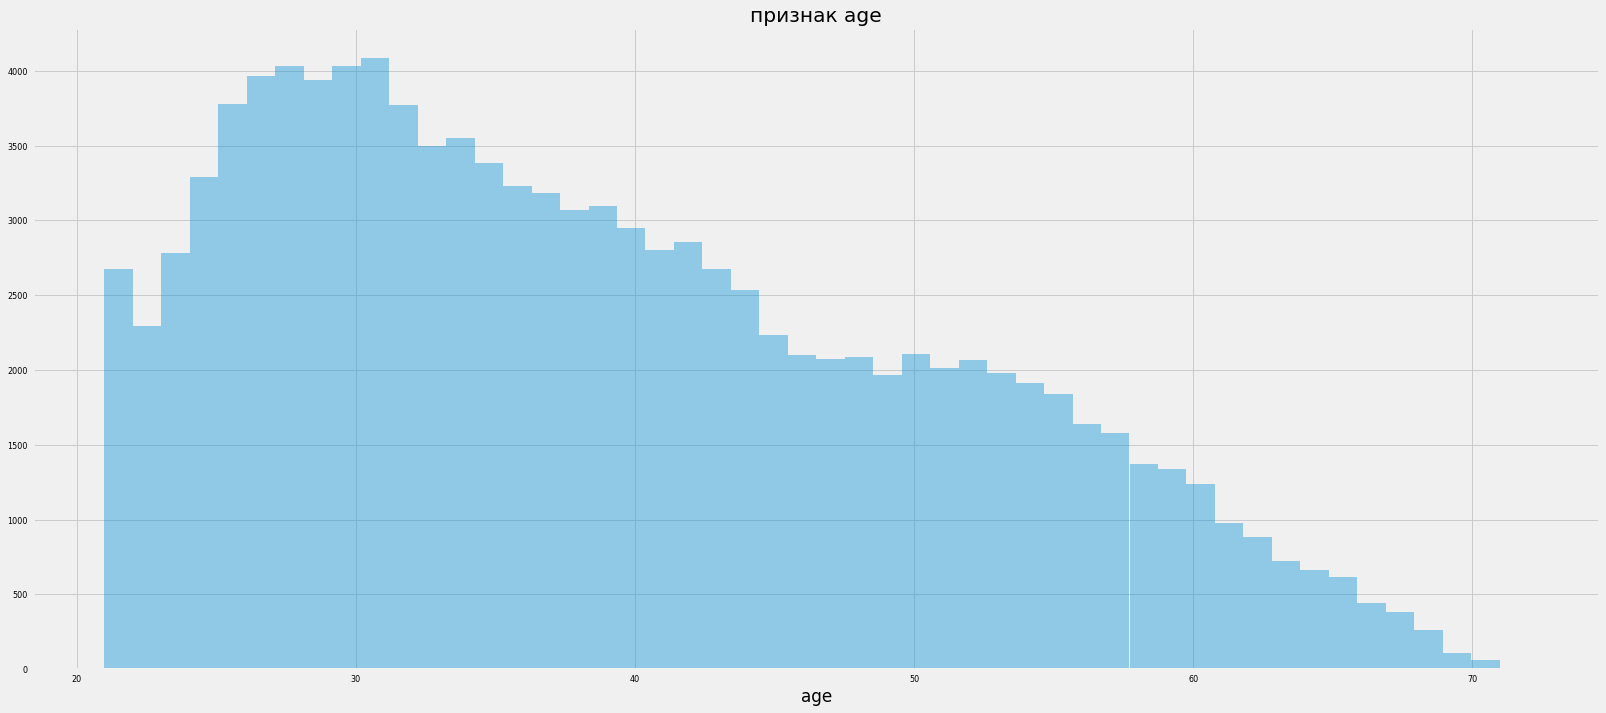

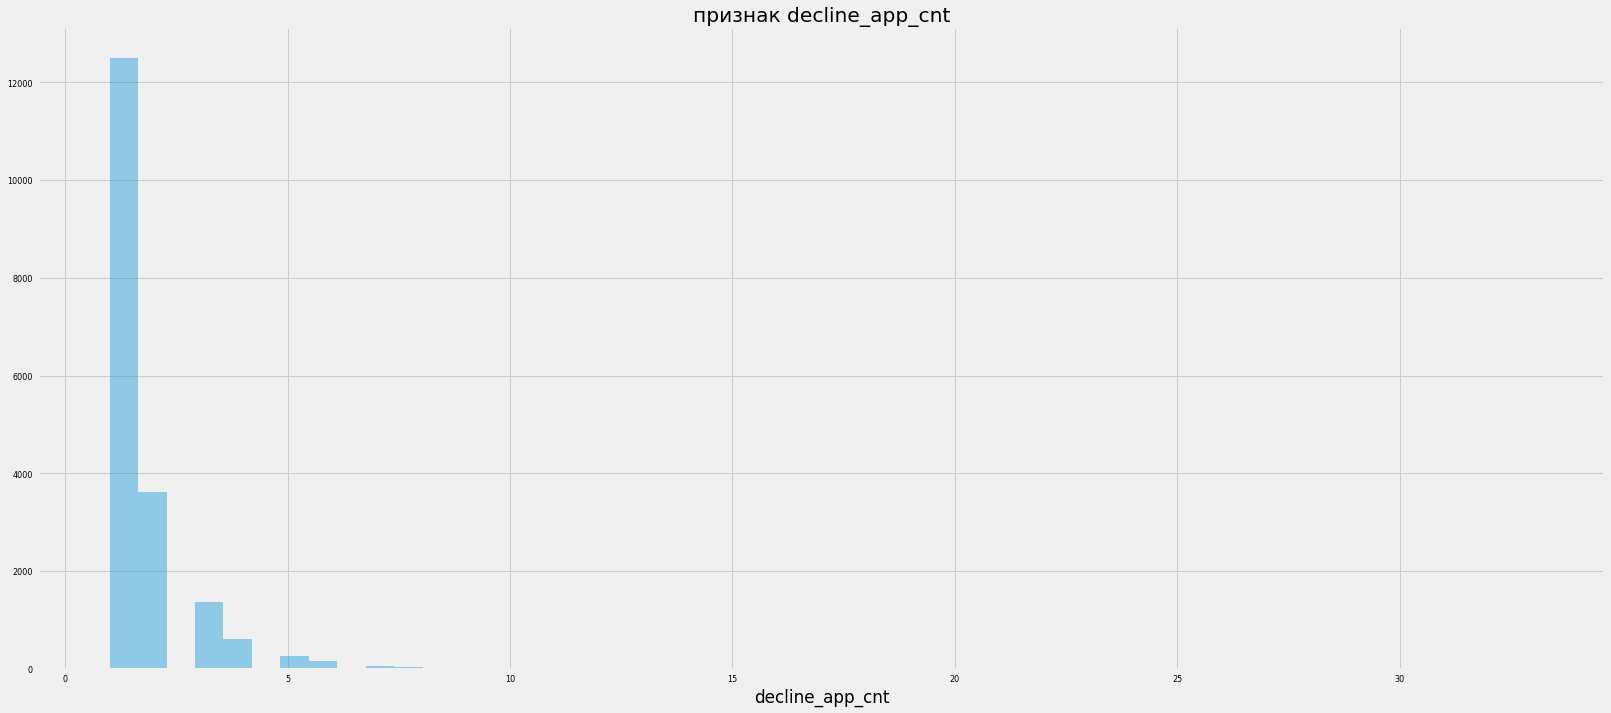

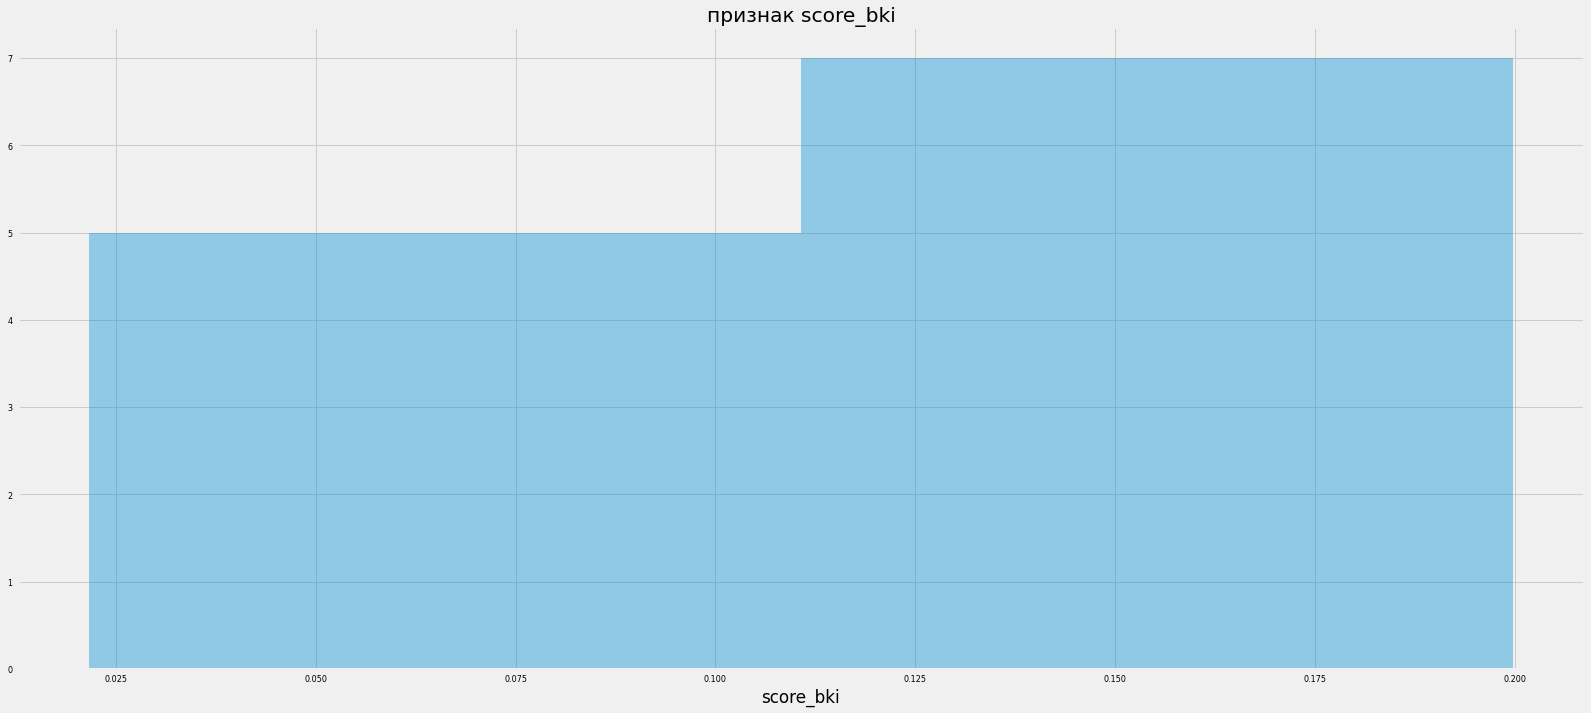

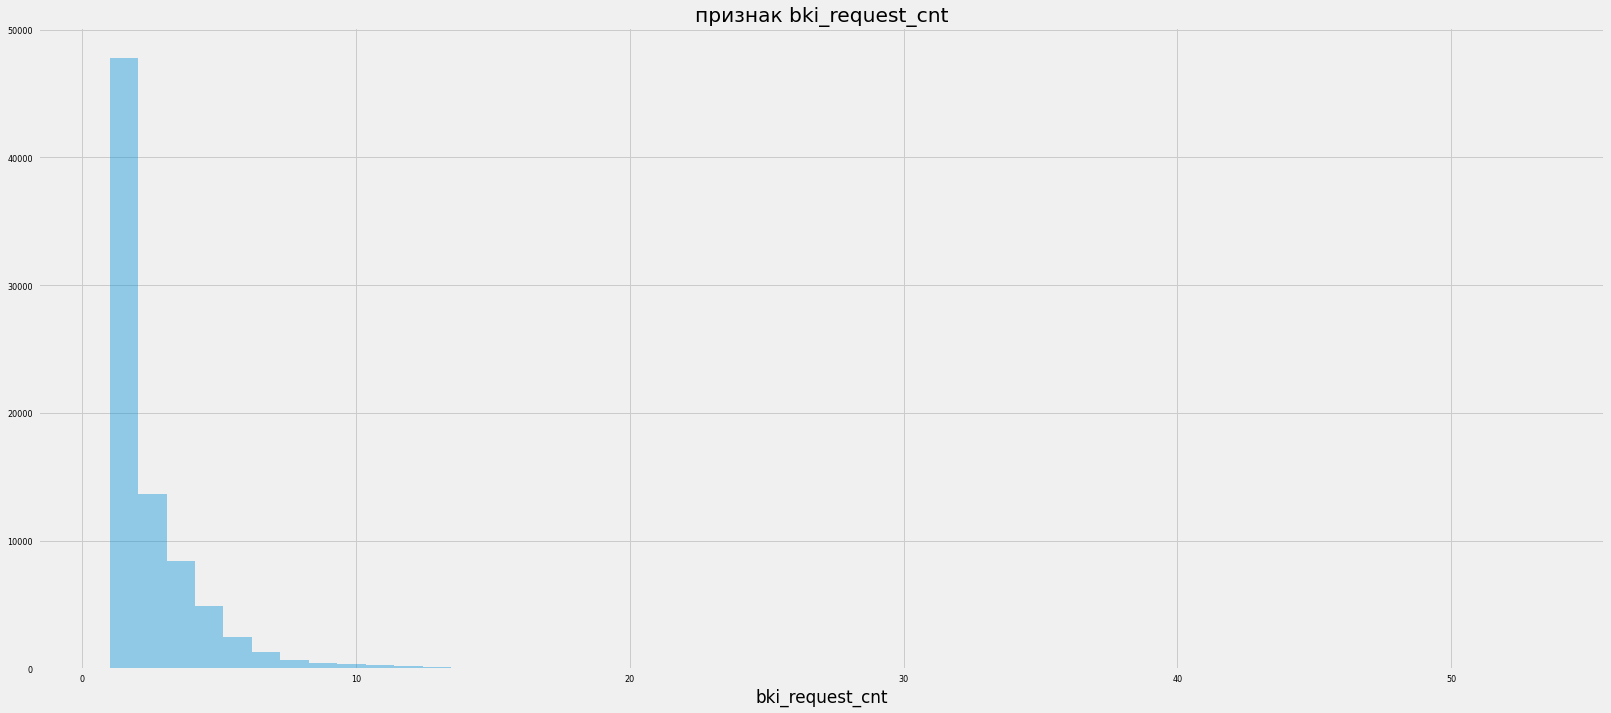

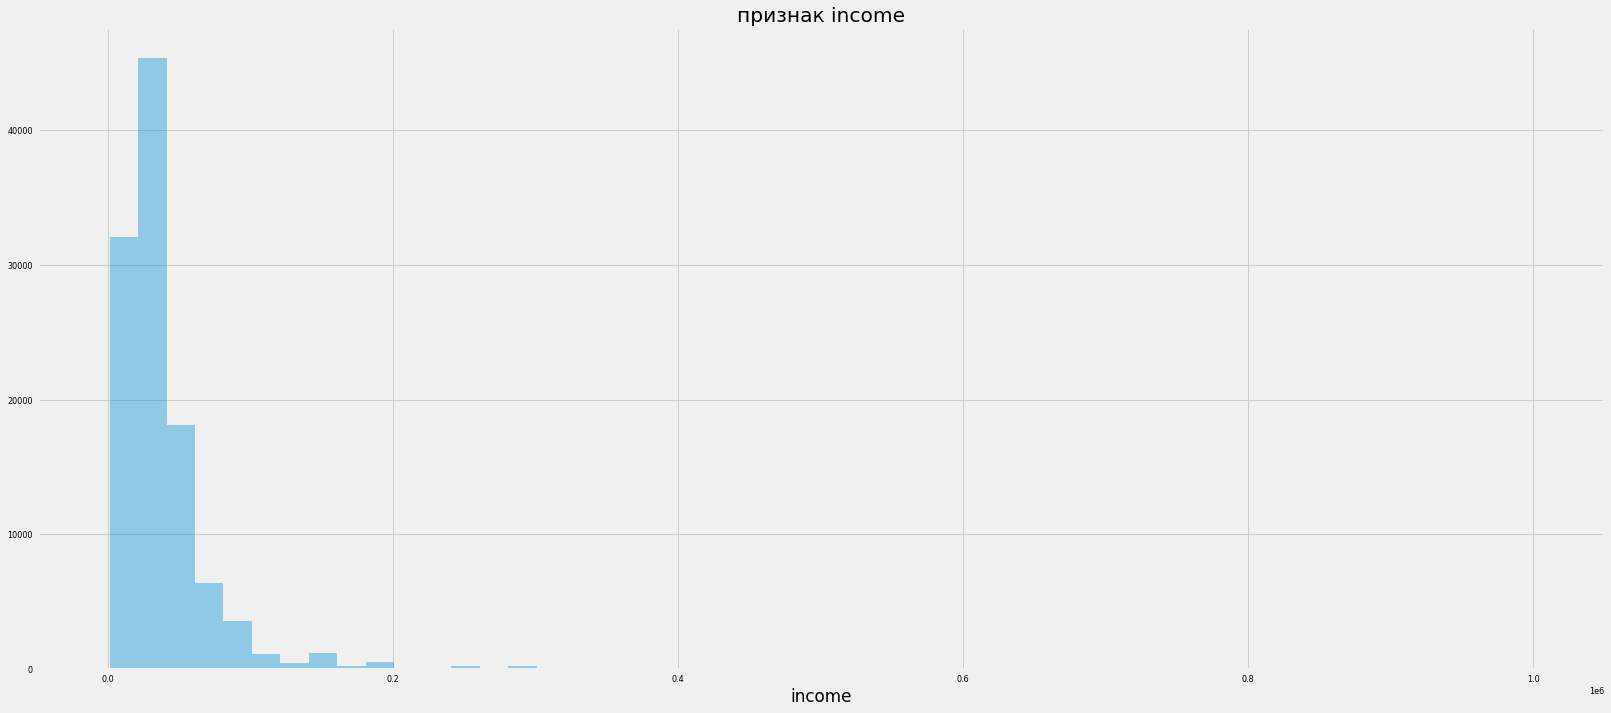

In [72]:
for i in num_cols:
    plt.figure(figsize=(25,11))
    sns.distplot(data[i][data[i] > 0], kde = False, rug=False)
    plt.title(f"признак {i}")
    plt.show()

После построения гистограмм стало очевидно, что распределения всех числовых переменных кроме score_bki имеют тяжёлый правый хвост.  
Стоит произвести логарифмирование данных, чтобы получить логнормальное распределение.

### Логарифмирование данных

In [73]:
# выполним логарифмирование числовых данных кроме признака score_bki
num_cols_to_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

for col in num_cols_to_log:
    data[col] = data[col].apply(lambda w: np.log(w + 1))

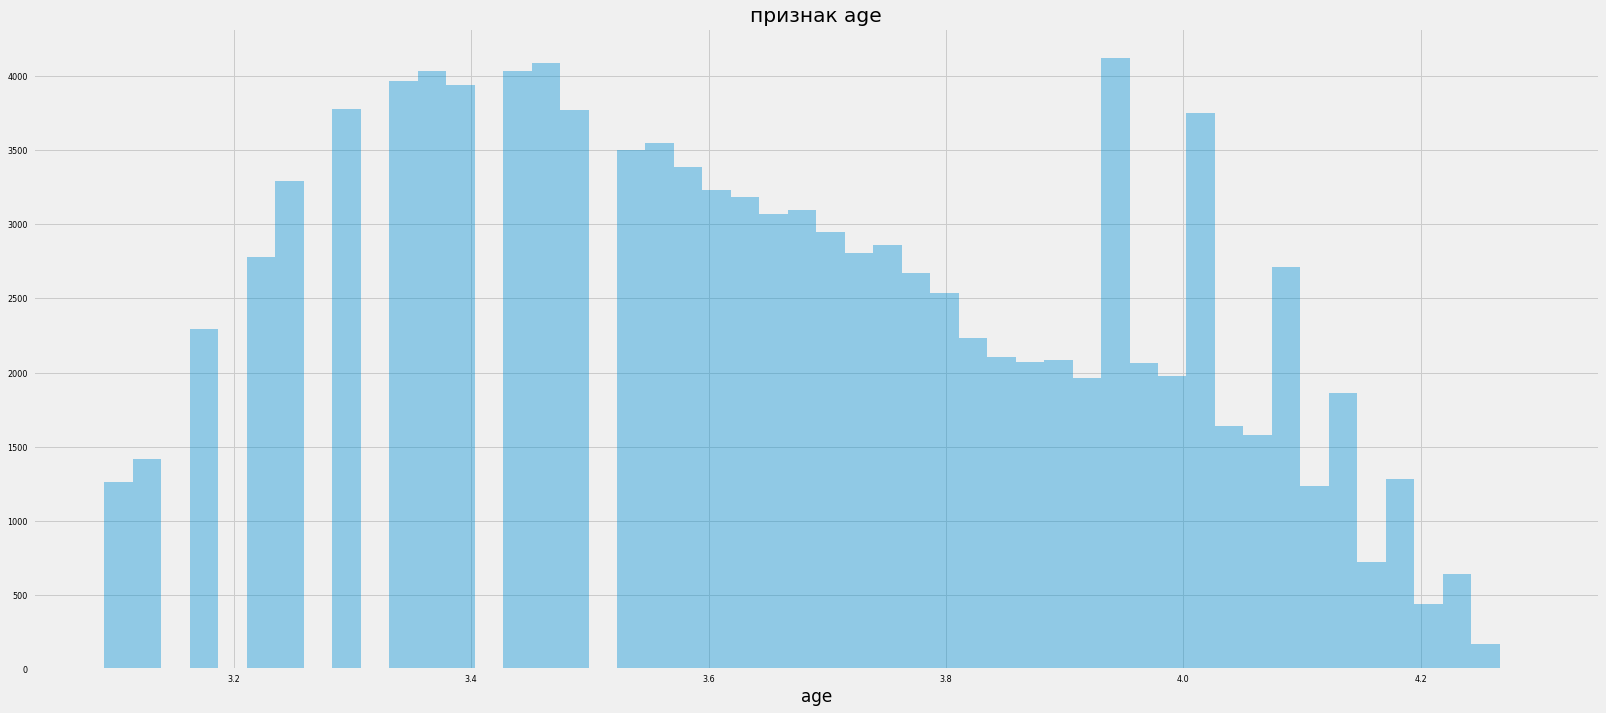

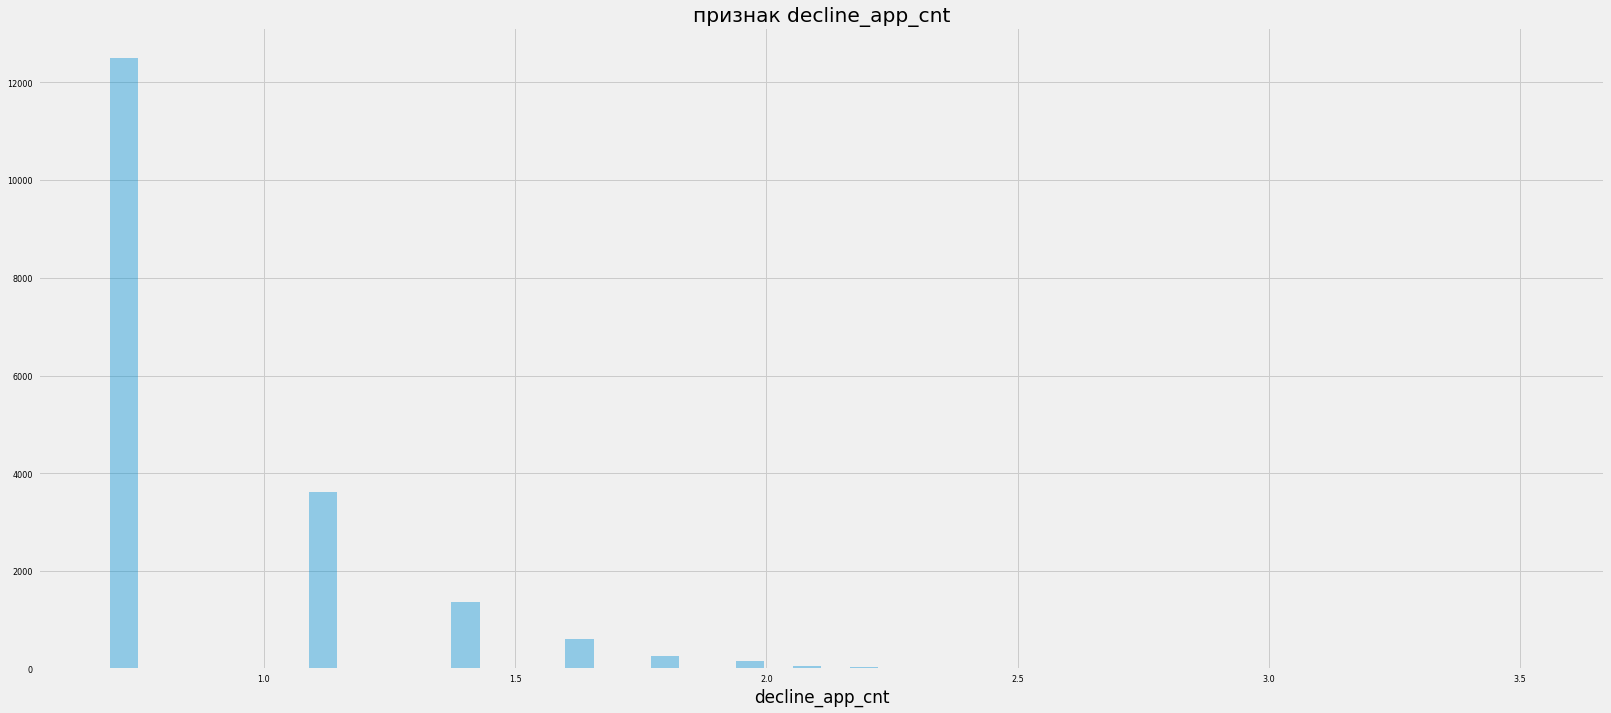

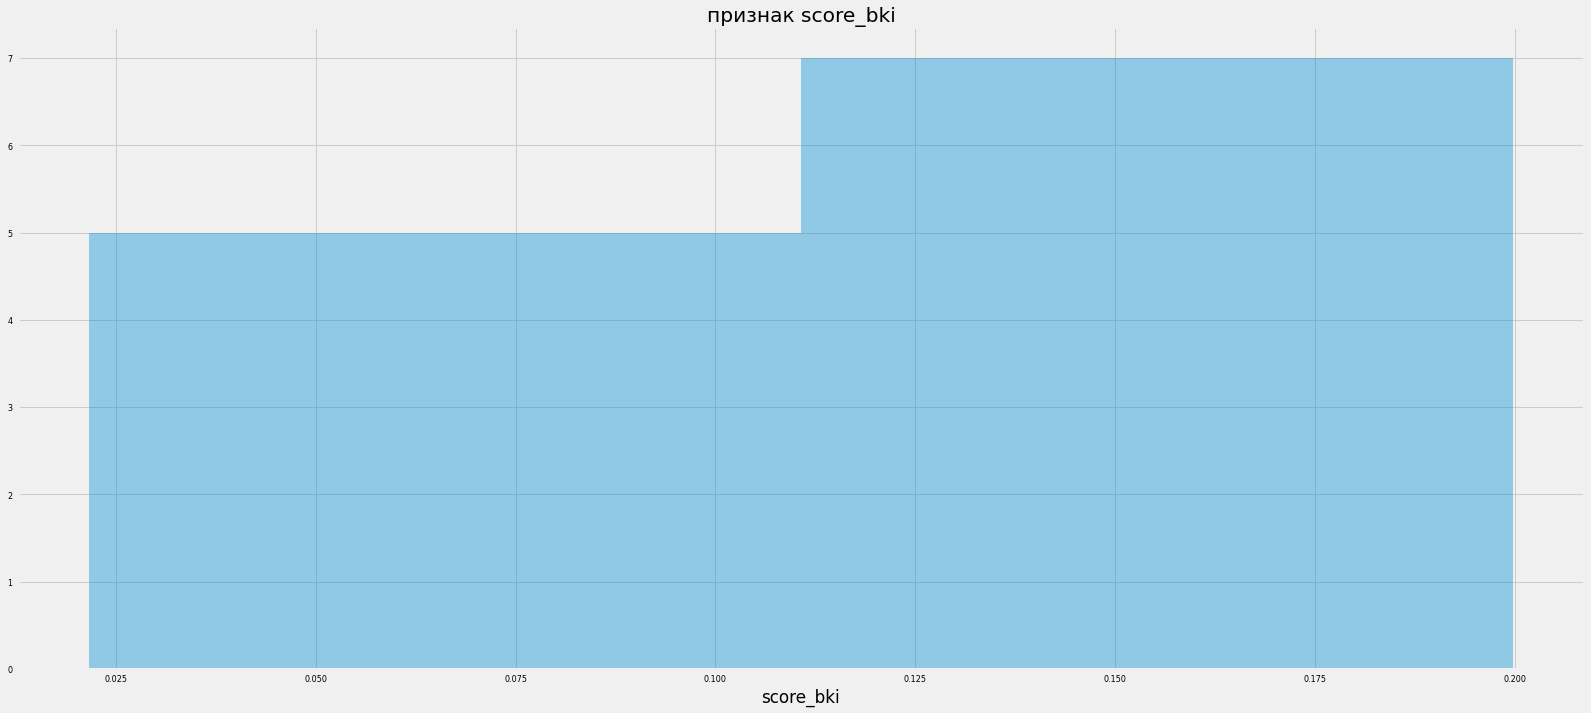

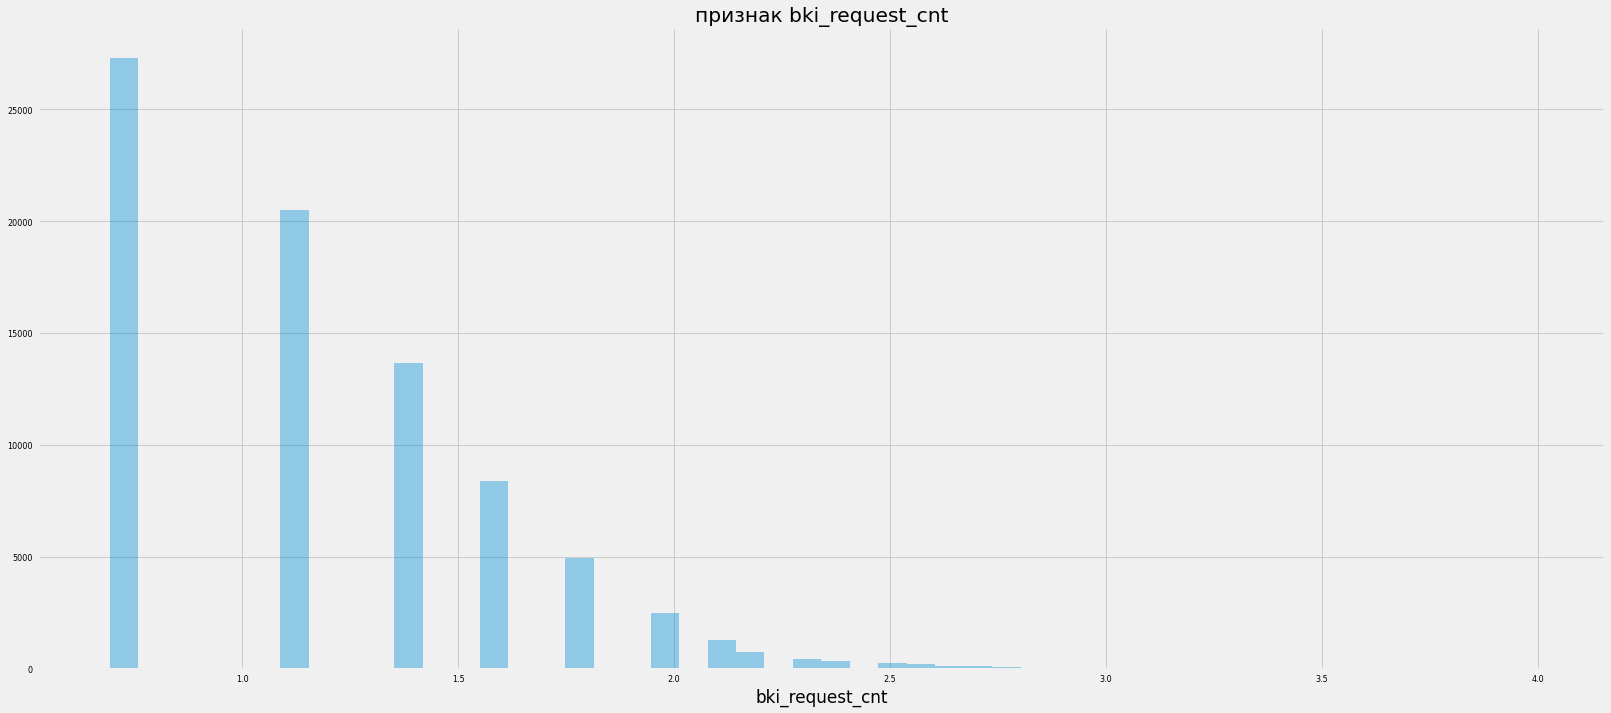

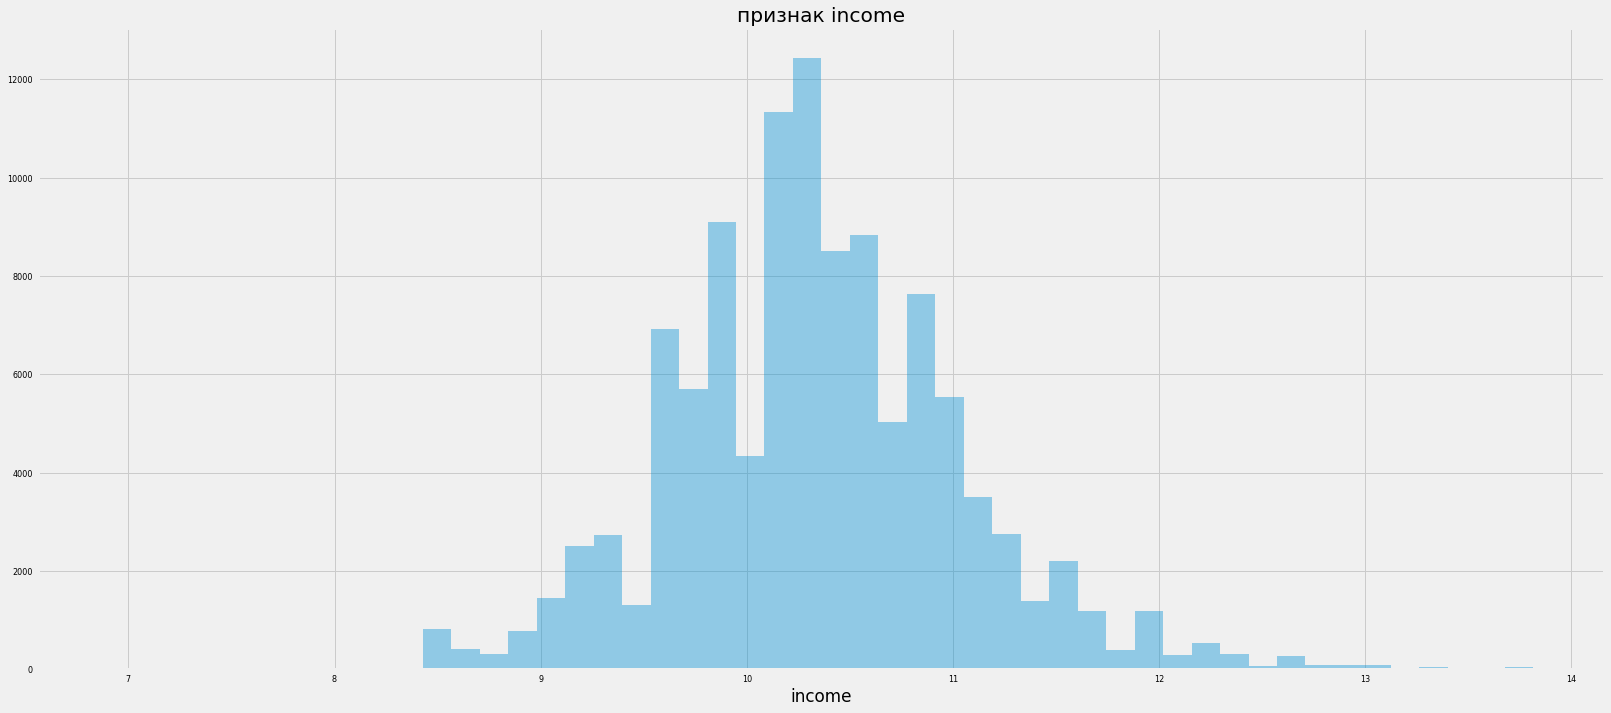

In [74]:
# оценим измененя в распределении после логарифмирования данных
for i in num_cols:
    plt.figure(figsize=(25,11))
    sns.distplot(data[i][data[i] > 0], kde = False, rug=False)
    plt.title(f"признак {i}")
    plt.show()

Часть признаков приобрело логнормальное расспределение.

## Построим boxplot'ы для численных переменных 

In [75]:
# Зададим функцию отрисовки boxplot'ов

def get_boxplot(df, feature, target):
    ax = sns.boxplot(x=target, y=feature, data=df)
    plt.title(f"{feature} vs {target}")

### Признак age 

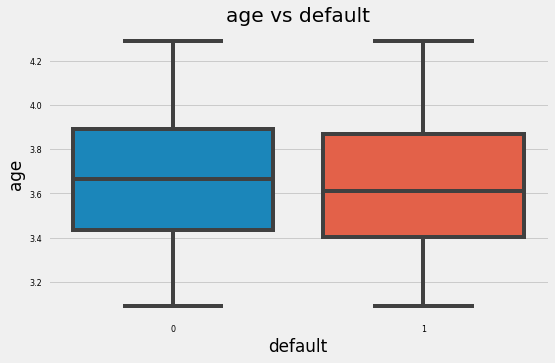

In [76]:
get_boxplot(data.loc[data['sample'] == 1], 'age', 'default')

Вывод:  
Дефолтные клиенты в среднем младше

### Признак decline_app_cnt 


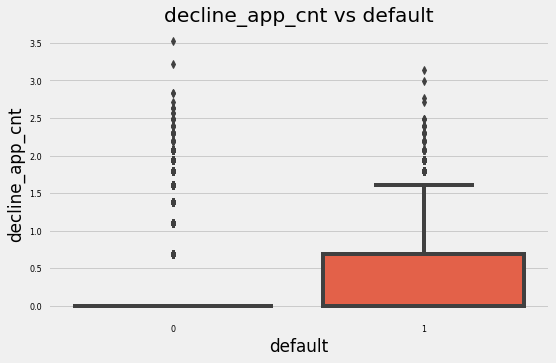

In [77]:
get_boxplot(data.loc[data['sample'] == 1], 'decline_app_cnt', 'default')

Вывод:  
Дефолтные клиенты имеют в среднем большее кол-во отклоненных заявок

### Признак bki_request_cnt 

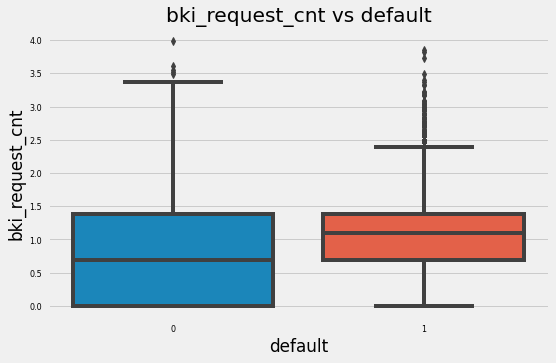

In [78]:
get_boxplot(data.loc[data['sample'] == 1], 'bki_request_cnt', 'default')

Вывод:  
Дефолтные клиенты в среднем подают большее кол-во заявок на кредиты

### Признак score_bki 

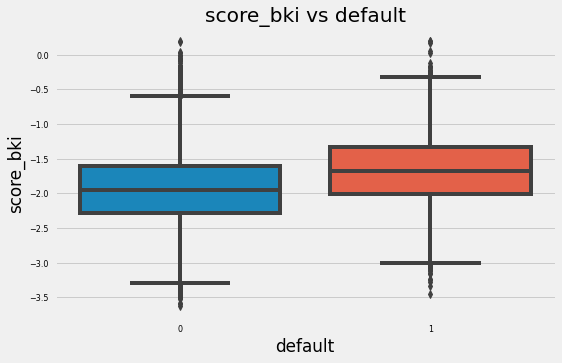

In [79]:
get_boxplot(data.loc[data['sample'] == 1], 'score_bki', 'default')

Дефолтные клиенты в среднем имеют чуть более низникое значение score_bki по модулю

### Признак income 

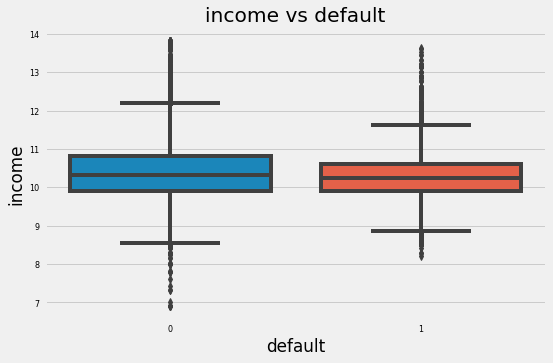

In [80]:
get_boxplot(data.loc[data['sample'] == 1], 'income', 'default')

Вывод:  
Дефолтные клиенты в среднем имеют доход чуть ниже

### Признак region_rating 

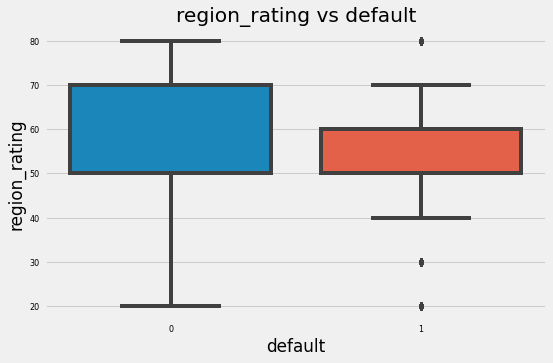

In [81]:
get_boxplot(data.loc[data['sample'] == 1], 'region_rating', 'default')

Дефолтные клиенты имеют более низкие значение признака region_rating.  
Судя по значениям этот признак является категориальным, чем непрерывным числовым.

### Новый признак days

In [82]:
# Выясняем начало и конец периода нашего датасета - это 1 января и 30 апреля 2014 года
start = data.app_date.min()
end = data.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

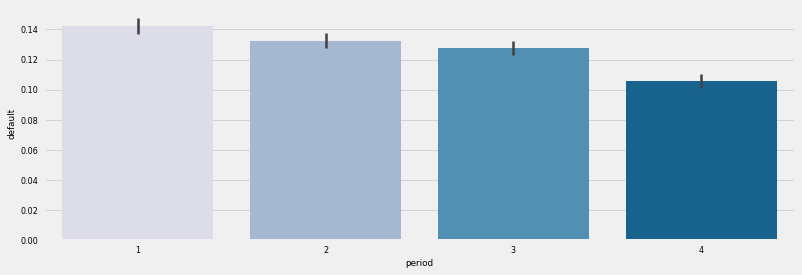

In [83]:
# Вводим 2 новых признака - номер дня с 1 января и номер месяца
data['days'] = (data.app_date - start).dt.days.astype('int')
data['period'] = data.app_date.dt.month.astype('int')

# Среднее число дефолтов по тренировочному датасету отрицательно коррелирует с месяцем подачи заявки
plt.style.use('seaborn-paper')
plt.subplots(figsize=(12, 4))
color_text = plt.get_cmap('PuBu')(0.85)
sns.barplot(data=data[data['sample']==1], x=data.loc[data['sample']==1,'period'], \
            y='default', palette="PuBu");

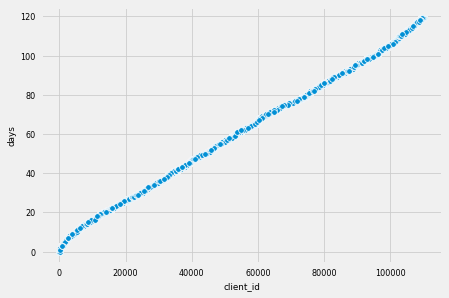

In [84]:
# Выясняем, что в банке велась сквозная нумерация клиентов в зависимости от дня обращения
sns.scatterplot(x='client_id',y='days',data=data)

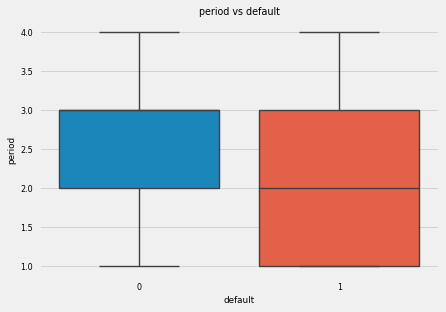

In [85]:
get_boxplot(data.loc[data['sample'] == 1], 'period', 'default')

Выводы:  
В среднем дефолтные заемщики блаки кредиты в более ранние месяцы.

In [86]:
# обновим данные по списками признаков
# временные переменные
time_cols = ['app_date']

# бинарные переменные
bin_cols = 'sex car car_type good_work foreign_passport'.split()

# категориальные переменные
cat_cols = 'education region_rating home_address work_address sna first_time period'.split()

# числовые переменные
num_cols = 'age decline_app_cnt score_bki bki_request_cnt income days'.split()

## Корреляция в данных

In [87]:
# Кореляция с целевым признаком и сротировка
correlations = data.loc[data['sample'] == 1].corr()['default'].sort_values(ascending=False)

# Отображение
print('Наивысшая позитивная корреляция: \n', correlations[1:5])
print('\nНаивысшая негативная коррелация: \n', correlations.tail(5))

Наивысшая позитивная корреляция: 
 score_bki          0.175369
sna                0.125832
decline_app_cnt    0.124027
home_address       0.084637
Name: default, dtype: float64

Наивысшая негативная коррелация: 
 good_work       -0.043361
income          -0.053871
region_rating   -0.089035
first_time      -0.105579
sample                NaN
Name: default, dtype: float64


Таким образом, все данные слабо коррелируют с целевым признаком. Однако выделяются 6 следующих признаков:
- **score_bki** (положительная корреляция) 
- **sna** (положительная корреляция)
- **decline_app_cnt** (положительная корреляция)
- **home_address** (положительная корреляция)
- **first_time** (отрицательная корреляция)
- **region_rating** (отрицательная корреляция)

### Посмотрим на матрицу корреляций в виде heatmap 

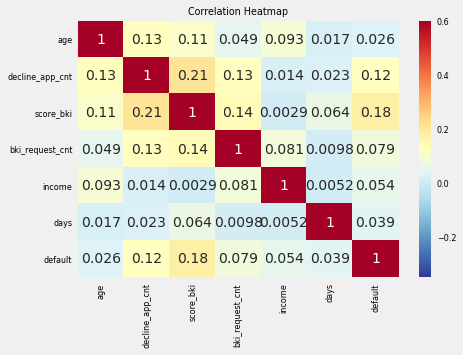

In [88]:
heat_cols = num_cols + ['default']
sns.heatmap(data.loc[data['sample'] == 1][heat_cols].corr().abs(), cmap = plt.cm.RdYlBu_r, \
            annot = True, vmin = -0.35, vmax = 0.6)
plt.title('Correlation Heatmap');

 Как видно все источники показывают слабую положительную корреляцию с целевым признаком.  
 Посмотрим на рапсределение KDE по каждому источнику.

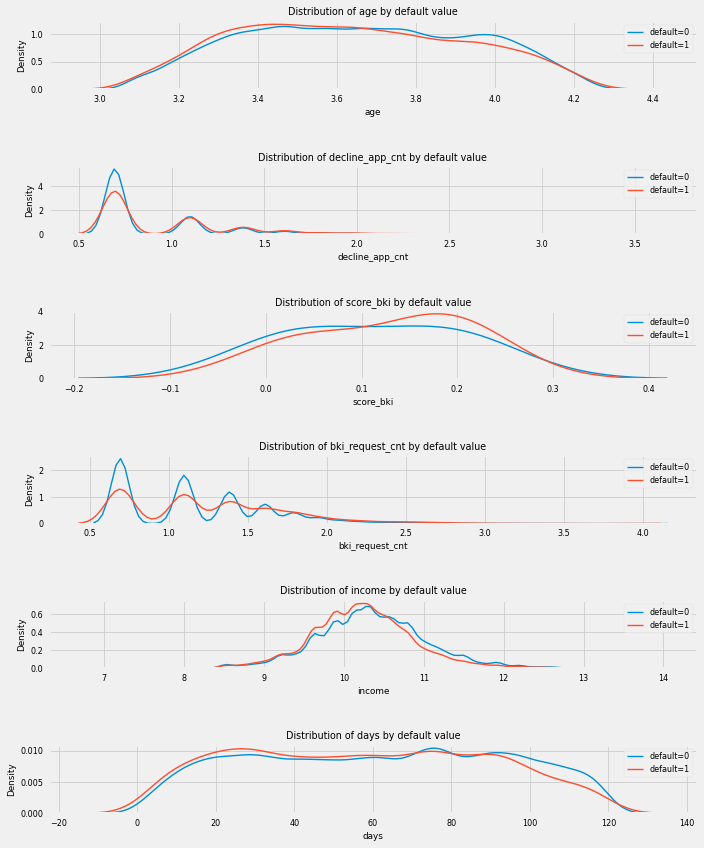

In [89]:
new_num_cols = ['age', 'score_bki', 'bki_request_cnt', 'region_rating', 'income', 'days']

plt.figure(figsize = (10, 12))

# # итерация по источникам
for i, source in enumerate(num_cols):
    
    
    # сабплот
    plt.subplot(6, 1, i + 1)
    # отрисовка качественных займов
    sns.kdeplot(data.loc[data['sample'] == 1].loc[(data['default'] == 0) & (data[source] > 0), source], label='default=0')
    # отрисовка дефолтных займов
    sns.kdeplot(data.loc[data['sample'] == 1].loc[(data['default'] == 1) & (data[source] > 0), source], label='default=1')
    
    # метки
    plt.title('Distribution of %s by default value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)


 Выводы:  
 По KDE-распределению так же подтверждаются выводы, полученные при построении boxplot'ов.  
 Так же добавлю, что с увеличением кол-ва дней от начала отсчета кол-во дефолтных клиентов падает.  
 Это может быт связано с оптимизацией внутренных процессов банка, изменении скоринговой системы и т.д.

## Исследование прочих признаков 
Рассмотрим более подробно другие признаки и зависимость целевой переменной. Так как среди них много категориальных, которые уже были закодированы, то нам снова понадобятся исходные данные.

### Значимость бинарных признаков
Сначала произведем кодирование признаков с помощью LabelEncoder

In [90]:
# Для бинарных признаков используем LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

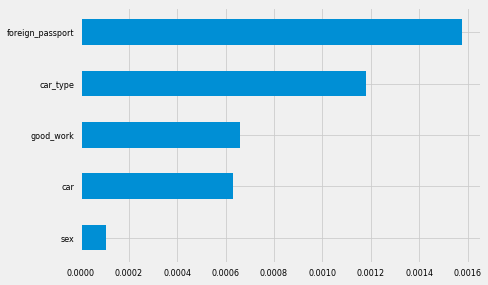

In [91]:
imp_cat = Series(mutual_info_classif(data[bin_cols], data['default'],
                                     discrete_features=True), index=bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Выводы:  
Самыми значимыми бинарными признаками является загран.паспорт и тип автомобиля ( иномарка).  
Такой признак как хорошая работа оказывает меньшее влияние.

In [92]:
# Так как мы уже произвели значительную обруботку данных, то удобнее 
# еще раз получить исходные выборки данных
app_train = pd.read_csv(PATH + 'train.csv', parse_dates=['app_date'])
app_test = pd.read_csv(PATH + 'test.csv', parse_dates=['app_date'])

In [93]:
# Функция для красивого отображения распределений и их влияния на целевую переменную
def plot_stats(df, feature,label_rotation=False,horizontal_layout=True):
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Количество займов': temp.values})

    # Расчет доли target=1 в категории
    cat_perc = df[[feature, 'default']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='default', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Количество займов",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='default', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Доля проблемных', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

### Рассмотрим основные признаки заемщиков 

### Пол клиента

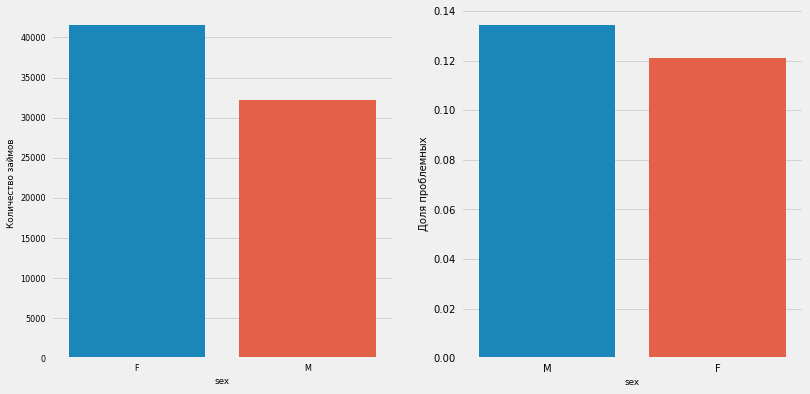

In [94]:
plot_stats(app_train, 'sex')

Выводы:  
Женщин-клиентов на четверть больше мужчин, при этом мужчины показывают гораздо более высокий риск дефолта.

### Владение машиной и машина иномарка 

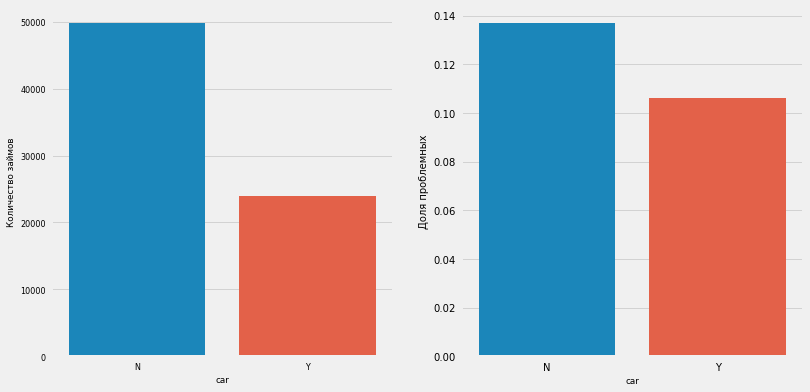

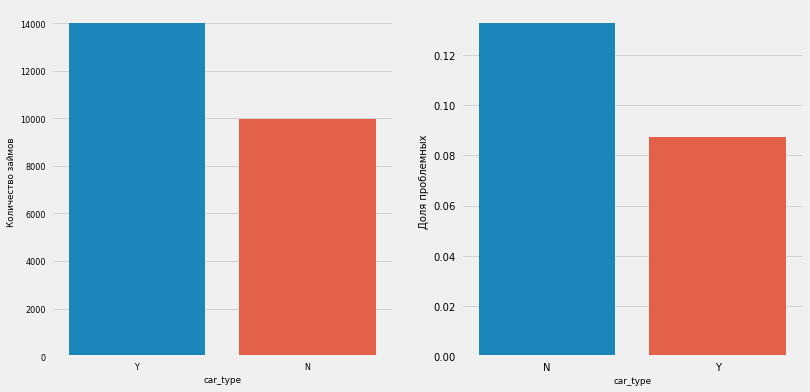

In [95]:
plot_stats(app_train, 'car')

car_df = app_train.loc[app_train.car == 'Y']
plot_stats(car_df, 'car_type')

Выводы:  
Заемщики без машины чаще обращаются к заемых средствам и чаще являются дефолтными клиентами для банка.   
Доля заемщиков, владеющих автомобиль импортного производства на 40% выше.  
Так же владельцы отечественных машин почти на 50% чаще становятсся дефолтными заемщиками.

### Уровень образования

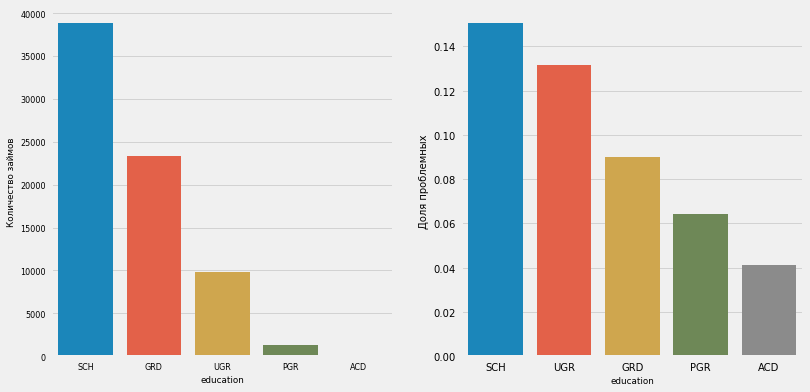

In [96]:
plot_stats(app_train, 'education')

Самые проблемные заемщики имеют образование SCH или UGR, а заемщики с образованием ACD почти не создают дефолтных ситуаций.  
Оно и понятно, ведь люди с образованием ACD почти не берут займов в банке.

### Хорошая работа или нет

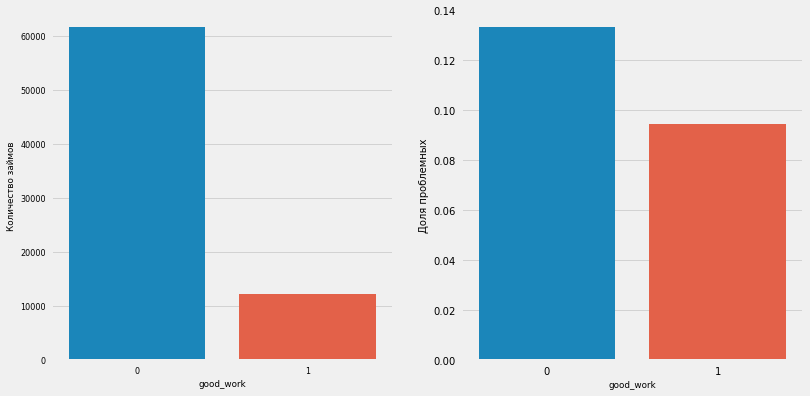

In [97]:
plot_stats(app_train, 'good_work')

Заемщики с плохой работой показывают более высокий риск дефолта.

### Рейтинг региона

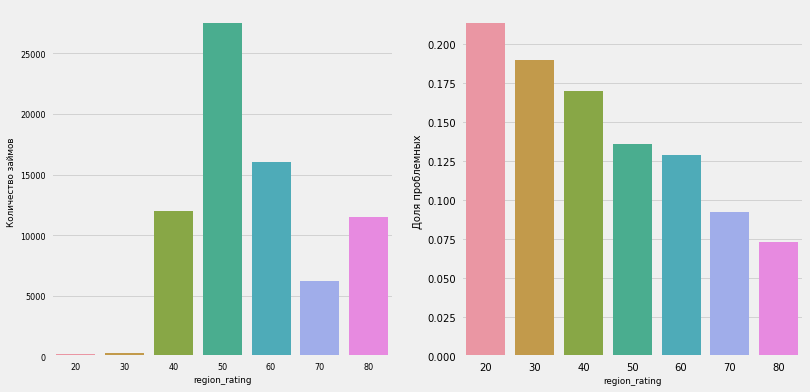

In [98]:
plot_stats(app_train, 'region_rating')

Тут наблюдается явная обратная корреляция кол-во дефолтов и рейтинг региона.  
Чем выше рейтинг, тем дефолтов меньше.

### Домашний адрес

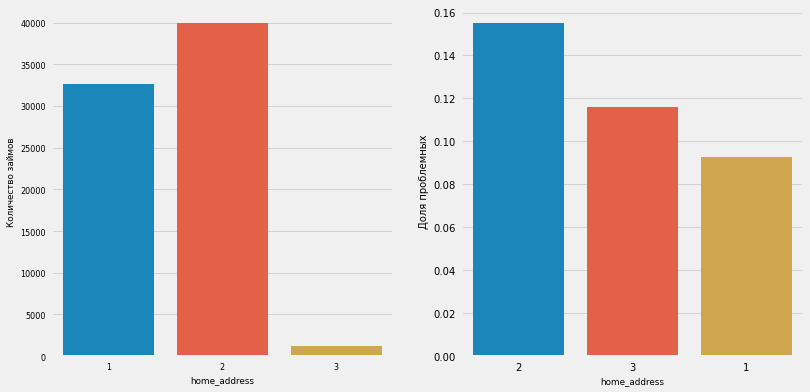

In [99]:
plot_stats(app_train, 'home_address')

Заемщики с домашним адресом 2 и 3 показывают более высокий риск дефолта.

### Рабочий адрес

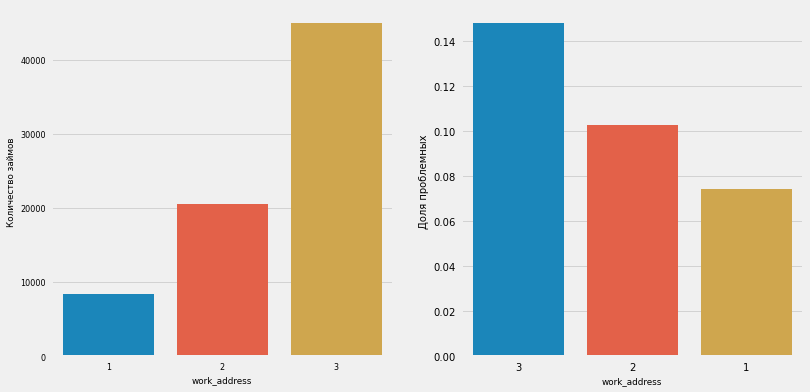

In [100]:
plot_stats(app_train, 'work_address')

Больше всего заемщиков с рабочим адресом равным 3, при это эта же категория заемщиеов самая проблемнная с точки зрения возможного дефолта.

### Признак sna

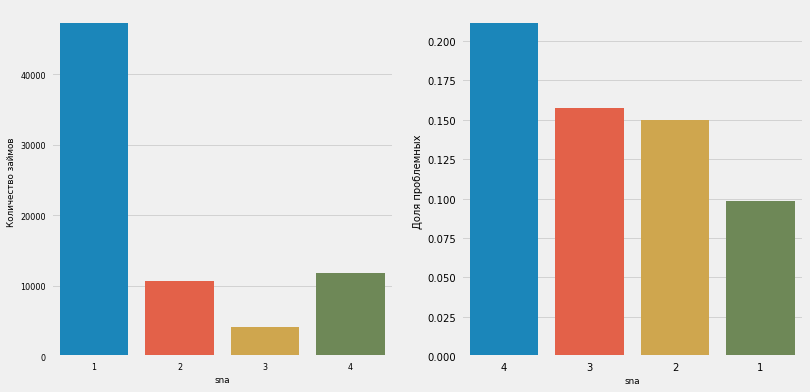

In [101]:
plot_stats(app_train, 'sna')

Самые проблемные заемщики имют значени признака sna равное 4.

### Признак first_time 

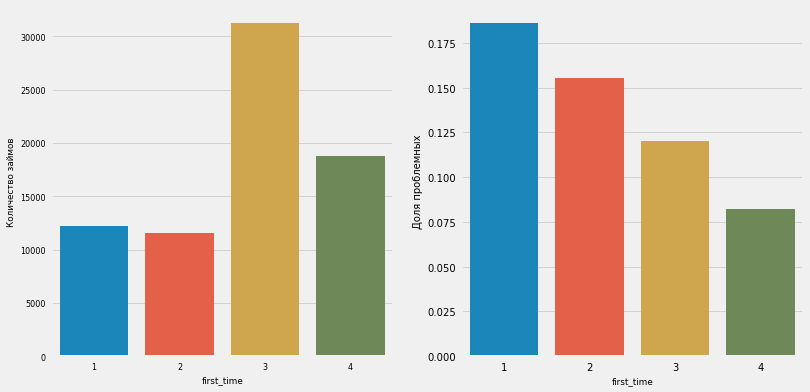

In [102]:
plot_stats(app_train, 'first_time')

Если этот признак означает сколько раз заемщик брал в банке кредит, то все данные очень красиво ложаться на эту гипотезу, так как самые проблемные заемщики брали кредит 1 раз. Проблемных клиентов банк больше не кредитовал, а заемщики с 3 и 4 повторными кредитными продуктами является самыми менее проблемными. 

### Признак foreign_passport

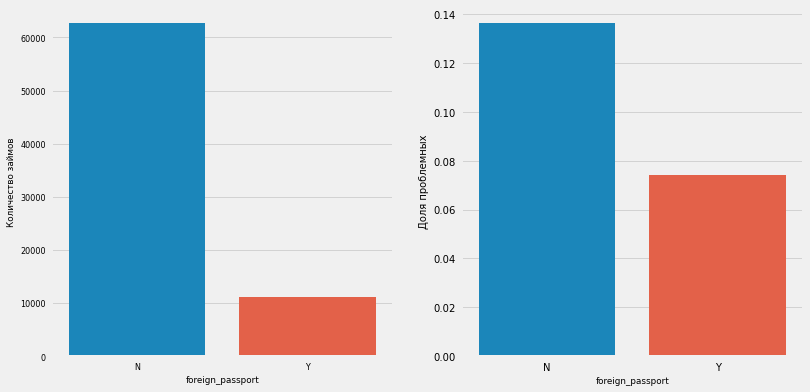

In [103]:
plot_stats(app_train, 'foreign_passport')

Заемщики без загран паспорта почти в 2 раза чаще становятся проблемными для банка.

### Ohe-кодирование категориальных переменных

In [104]:
# Ohe-кодирование категориальных переменных
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

In [105]:
# Визуально оценим результат ohe-кодирования
data.head()

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,sample,default,education_isNAN,days,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,period_1,period_2,period_3,period_4
0,74835,2014-03-22,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,10.819798,0,0,0,0,80,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0
1,17527,2014-01-24,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,8.517393,0,0,0,0,23,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0
2,75683,2014-03-23,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,10.308986,1,0,0,0,81,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0
3,26883,2014-02-03,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,9.741027,0,0,0,0,33,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
4,28862,2014-02-04,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,11.695255,0,0,0,0,34,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0


## Feature Engineering
### Полиномиальные признаки
Для удобства обработки ссоздадим новый датафрейм для полиномиальных признаков

In [106]:
# создадим новый датафрейм для полиномиальных признаков
poly_features = data[num_cols]
print('Формат полиномиальных признаков: ', poly_features.shape)

Формат полиномиальных признаков:  (110148, 6)


In [ ]:
num_cols

In [107]:
# Создадим полиномиальный объект степени 3
poly_transformer = PolynomialFeatures(degree = 3)


# Тренировка полиномиальных признаков
poly_transformer.fit(poly_features)

# Трансформация признаков
poly_features = poly_transformer.transform(poly_features)[:, 1:]
print('Формат полиномиальных признаков: ', poly_features.shape)

Формат полиномиальных признаков:  (110148, 83)


In [108]:
# Датафрейм для новых фич 
poly_features = pd.DataFrame(poly_features, 
                             columns=poly_transformer.get_feature_names(input_features=num_cols)[1:84])

# Добавим таргет
poly_features['default'] = data.default

# Добавим метку тестовой выборки с синтетическими значениями таргета
poly_features['sample'] = data['sample']

# рассчитаем корреляцию на тренировочной выборке
poly_corrs = poly_features.loc[poly_features['sample'] == 1].corr()['default'].sort_values(ascending=False)

# Отобразим признаки с наивысшей корреляцией
print(poly_corrs.head(28))
print(poly_corrs.tail(6))

default                                   1.000000
score_bki income                          0.181050
age score_bki income                      0.177205
score_bki income^2                        0.175679
score_bki                                 0.175369
age score_bki                             0.170307
score_bki^3                               0.156332
age^2 score_bki                           0.155898
decline_app_cnt                           0.124027
age decline_app_cnt                       0.123321
decline_app_cnt income                    0.121849
age^2 decline_app_cnt                     0.121635
age decline_app_cnt income                0.121161
decline_app_cnt income^2                  0.119036
decline_app_cnt bki_request_cnt           0.117100
age decline_app_cnt bki_request_cnt       0.116584
decline_app_cnt bki_request_cnt income    0.114884
decline_app_cnt^2                         0.112350
age decline_app_cnt^2                     0.112333
decline_app_cnt^2 income       

In [112]:
poly_corrs.index[1:24]

Index(['score_bki income', 'age score_bki income', 'score_bki income^2',
       'score_bki', 'age score_bki', 'score_bki^3', 'age^2 score_bki',
       'decline_app_cnt', 'age decline_app_cnt', 'decline_app_cnt income',
       'age^2 decline_app_cnt', 'age decline_app_cnt income',
       'decline_app_cnt income^2', 'decline_app_cnt bki_request_cnt',
       'age decline_app_cnt bki_request_cnt',
       'decline_app_cnt bki_request_cnt income', 'decline_app_cnt^2',
       'age decline_app_cnt^2', 'decline_app_cnt^2 income',
       'score_bki income days', 'age score_bki days', 'score_bki days',
       'decline_app_cnt^2 bki_request_cnt'],
      dtype='object')

In [113]:
# Отберем часть поли-признаков, со значением корреляции не ниже 0.1 по модулю
# после удаления выбросов
# new_poly_cols = list(poly_corrs.index[1:10]) + list(poly_corrs.index[-3:-1])

# до удаления выбросов
new_poly_cols = list(poly_corrs.index[1:24]) + list(poly_corrs.index[-5:-1])

print(f"Размер poly-признаков: {len(new_poly_cols)}")
print(new_poly_cols)

Размер poly-признаков: 27
['score_bki income', 'age score_bki income', 'score_bki income^2', 'score_bki', 'age score_bki', 'score_bki^3', 'age^2 score_bki', 'decline_app_cnt', 'age decline_app_cnt', 'decline_app_cnt income', 'age^2 decline_app_cnt', 'age decline_app_cnt income', 'decline_app_cnt income^2', 'decline_app_cnt bki_request_cnt', 'age decline_app_cnt bki_request_cnt', 'decline_app_cnt bki_request_cnt income', 'decline_app_cnt^2', 'age decline_app_cnt^2', 'decline_app_cnt^2 income', 'score_bki income days', 'age score_bki days', 'score_bki days', 'decline_app_cnt^2 bki_request_cnt', 'score_bki^2 days', 'age score_bki^2', 'score_bki^2', 'score_bki^2 income']


Некоторые признаки показывают более высокую корреляцию, чем исходные. Есть смысл попробовать обучить модель с ними и без них.  

После удаления выбросов значения корреляции поли-признаков сильно упали почти до нуля

In [114]:
poly_features = poly_features[new_poly_cols]
print('Формат полиномиальных признаков: ', poly_features.shape)

Формат полиномиальных признаков:  (110148, 27)


### Объединение выборок

In [115]:
# Добавим признак client_id
poly_features['client_id'] = data.client_id

data_poly = data.merge(poly_features, on='client_id', how='left')

# Посмотрим формат
print('Формат выборки с полиномиальными признаками: ', data_poly.shape)

Формат выборки с полиномиальными признаками:  (110148, 73)


In [116]:
data_poly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 110147
Data columns (total 73 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   client_id                               110148 non-null  int64         
 1   app_date                                110148 non-null  datetime64[ns]
 2   sex                                     110148 non-null  int64         
 3   age                                     110148 non-null  float64       
 4   car                                     110148 non-null  int64         
 5   car_type                                110148 non-null  int64         
 6   decline_app_cnt_x                       110148 non-null  float64       
 7   good_work                               110148 non-null  int64         
 8   score_bki_x                             110148 non-null  float64       
 9   bki_request_cnt                      

In [118]:
# оценим данные визуально
data_poly.head()

,client_id,app_date,sex,age,car,car_type,decline_app_cnt_x,good_work,score_bki_x,bki_request_cnt,income,foreign_passport,sample,default,education_isNAN,days,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,period_1,period_2,period_3,period_4,score_bki income,age score_bki income,score_bki income^2,score_bki_y,age score_bki,score_bki^3,age^2 score_bki,decline_app_cnt_y,age decline_app_cnt,decline_app_cnt income,age^2 decline_app_cnt,age decline_app_cnt income,decline_app_cnt income^2,decline_app_cnt bki_request_cnt,age decline_app_cnt bki_request_cnt,decline_app_cnt bki_request_cnt income,decline_app_cnt^2,age decline_app_cnt^2,decline_app_cnt^2 income,score_bki income days,age score_bki days,score_bki days,decline_app_cnt^2 bki_request_cnt,score_bki^2 days,age score_bki^2,score_bki^2,score_bki^2 income
0,74835,2014-03-22,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,10.819798,0,0,0,0,80,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,-24.581323,-83.605932,-265.964957,-2.271884,-7.727125,-11.726226,-26.281477,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1966.505843,-618.169983,-181.750694,0.000000,412.916433,17.555129,5.161455,55.845906
1,17527,2014-01-24,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,8.517393,0,0,0,0,23,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,-12.818669,-47.286526,-109.181648,-1.504999,-5.551760,-3.408857,-20.479775,1.791759,6.609585,15.26112,24.381961,56.296432,129.984958,1.968449,7.261371,16.766054,3.210402,11.842786,27.344256,-294.829398,-127.690490,-34.614980,3.526987,52.095516,8.355395,2.265022,19.292087
2,75683,2014-03-23,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,10.308986,1,0,0,0,81,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,-17.435990,-68.555274,-179.747382,-1.691339,-6.650050,-4.838291,-26.146838,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1412.315228,-538.654065,-136.998462,0.000000,231.710848,11.247490,2.860628,29.490171
3,26883,2014-02-03,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,9.741027,0,0,0,0,33,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,-23.126977,-93.503552,-225.280515,-2.374182,-9.598941,-13.382655,-38.809013,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-763.190231,-316.765069,-78.348022,0.000000,186.012501,22.789639,5.636742,54.907663
4,28862,2014-02-04,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,11.695255,0,0,0,0,34,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,-29.091976,-106.580247,-340.238085,-2.487502,-9.113118,-15.391839,-33.386471,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-989.127176,-309.846025,-84.575082,0.000000,210.380718,22.668904,6.187668,72.366360


In [119]:
print(f"Размерной датасета с poly-признаками: {data_poly.shape}")

Размерной датасета с poly-признаками: (110148, 73)


In [120]:
# Удалим признак app_date, как не числовой
data_poly.drop(labels=['app_date'], inplace=True, axis=1)

## Тренировка модели c полиномиальными признаками 

In [122]:
from sklearn.preprocessing import MinMaxScaler

# Разделим данные на тренировочную и тестовую выборки
train = data_poly.loc[data_poly['sample'] == 1].drop(labels=['sample', 'client_id'], axis=1)
train_y = train.default.values
train_x = train.drop(labels=['default'], axis=1).values

# так же удаляем default, так как он синтетический
test_x = data_poly.loc[data_poly['sample'] == 0].drop(labels=['sample', 'default', 'client_id'], axis=1).values

# Нормализация
scaler = MinMaxScaler(feature_range = (0, 1))


# Трансофрмация тренировочной с нормализацией
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)


In [123]:
train_x_cols = train.drop(labels=['default'], axis=1).columns
train_x_cols

Index(['sex', 'age', 'car', 'car_type', 'decline_app_cnt_x', 'good_work',
       'score_bki_x', 'bki_request_cnt', 'income', 'foreign_passport',
       'education_isNAN', 'days', 'education_ACD', 'education_GRD',
       'education_PGR', 'education_SCH', 'education_UGR', 'region_rating_20',
       'region_rating_30', 'region_rating_40', 'region_rating_50',
       'region_rating_60', 'region_rating_70', 'region_rating_80',
       'home_address_1', 'home_address_2', 'home_address_3', 'work_address_1',
       'work_address_2', 'work_address_3', 'sna_1', 'sna_2', 'sna_3', 'sna_4',
       'first_time_1', 'first_time_2', 'first_time_3', 'first_time_4',
       'period_1', 'period_2', 'period_3', 'period_4', 'score_bki income',
       'age score_bki income', 'score_bki income^2', 'score_bki_y',
       'age score_bki', 'score_bki^3', 'age^2 score_bki', 'decline_app_cnt_y',
       'age decline_app_cnt', 'decline_app_cnt income',
       'age^2 decline_app_cnt', 'age decline_app_cnt income',
      

### Разбиение выборки на train и test

In [124]:
# Разбиение выборки
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.20, \
                                                    random_state=RANDOM_SEED)


### ПОДБОР ГИПЕРПАРАМЕТРОВ МОДЕЛИ ПО МЕТОДУ СОКОЛОВА 

In [125]:
# данный блок задокомментирован, так как подбор параметров занимает примерно 30 минут. 
# Оптимальные параметры будут использоваться ниже.

# запускаем GridSearch на небольшом кол-ве итераций max_iter=100 и с достаточно большим шагом останова tol1e-4
# чтобы получить оптимальные параметры в первом приближении
# model = LogisticRegression(random_state=RANDOM_SEED)

# start = datetime.now()
# param_grid = [
#     {'penalty': ['l1'], 'C':[0.1, 1, 10], 'solver': ['liblinear', 'saga'], 'class_weight':['none', 'balanced'], 'multi_class': ['auto','ovr'], 'max_iter':[100],'tol':[1e-4]},
#     {'penalty': ['l2'], 'C':[0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'class_weight':['none', 'balanced'], 'multi_class': ['auto','ovr'], 'max_iter':[100],'tol':[1e-4]},
#     {'penalty': ['none'], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'class_weight':['none', 'balanced'], 'multi_class': ['auto','ovr'], 'max_iter':[100],'tol':[1e-4]},
# ]
# gridsearch = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=5)
# gridsearch.fit(X_train, y_train)
# model = gridsearch.best_estimator_
# ##печатаем параметры
# best_parameters = model.get_params()
# for param_name in sorted(best_parameters.keys()):
#         print('\t%s: %r' % (param_name, best_parameters[param_name]))
#     ##печатаем метрики
# preds = model.predict(X_test)
# print('Accuracy: %.4f' % accuracy_score(y_test, preds))
# print('Precision: %.4f' % precision_score(y_test, preds))
# print('Recall: %.4f' % recall_score(y_test, preds))
# print('F1: %.4f' % f1_score(y_test, preds))

# print(f"Total time: {start - datetime.now()}")

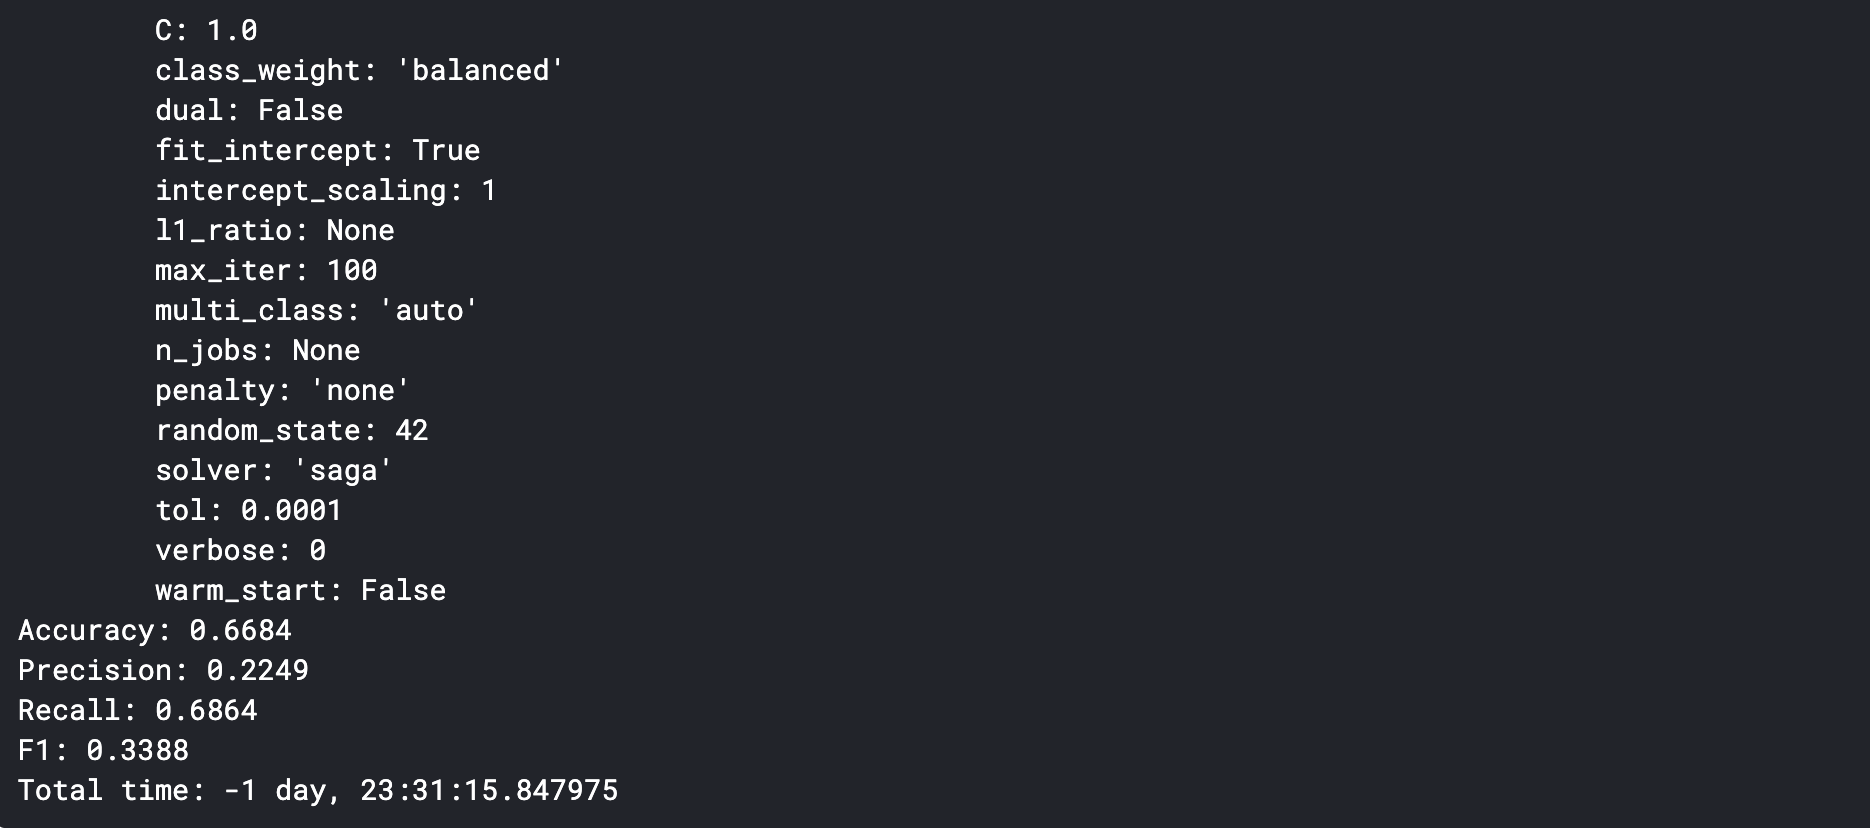

Обучим модель и посмотрим, что получилось.

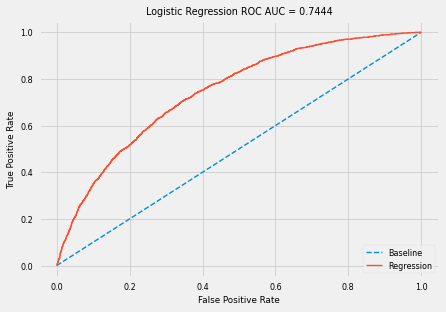

In [126]:
# вторая модель на парамтрах после первой оптимизации
model = LogisticRegression(random_state=RANDOM_SEED, C=1, class_weight= 'balanced', \
                           dual= False, fit_intercept= True, intercept_scaling= 1, \
                           l1_ratio= None, max_iter=100, multi_class= 'ovr', n_jobs= None, \
                           penalty= 'l2', solver = 'liblinear', verbose= 0, warm_start= False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### Оценка точности модели 

In [128]:
# зададим несколько функций для оценки предсказаний
def plot_confusion_matrix(y_true, y_pred, d_my_font_scale, classes,
                          normalize=False,
                          title=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    list_of_labels = [['TP','FP'],['FN','TN']]
    
    if not title:
        if normalize:
            title = 'Нормализованная матрица ошибок'
        else:
            title = 'Матрица ошибок без нормализации'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]

    # # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   

    plt.style.use('seaborn-paper')
    cmap=plt.cm.Blues
    color_text = plt.get_cmap('PuBu')(0.85)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           
           title=title)
    ax.title.set_fontsize(15)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color = color_text)
    ax.set_xlabel('Целевая переменная', fontsize=14, color = color_text)
    ax.set_xticklabels(classes, fontsize=12, color = 'black')
    ax.set_yticklabels(classes, fontsize=12, color = 'black')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, list_of_labels[i][j]+'\n'+format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def confusion_matrix_f(d_name_columns, d_y, d_y_pred, d_my_font_scale, normalize=False):

    class_names  = np.array(d_name_columns, dtype = 'U10')
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(d_y, d_y_pred, d_my_font_scale, classes=class_names,
                        title='Матрица ошибок без нормализации')

    # Plot normalized confusion matrix
    if normalize:
        plot_confusion_matrix(d_y, d_y_pred, d_my_font_scale, classes=class_names, normalize=True,
                        title='Нормализованная матрица ошибок')

    plt.show()
    return


def ROC_curve_with_area(d_y_true, d_y_pred_prob, d_my_font_scale):
    roc_auc_score_f = roc_auc_score(d_y_true, d_y_pred_prob)

    plt.style.use('seaborn-paper')
    sns.set(font_scale=d_my_font_scale)
    # sns.set_color_codes("muted")

    plt.figure(figsize=(8, 6))
    fpr, tpr, thresholds = roc_curve(d_y_true, d_y_pred_prob, pos_label=1)

    plt.plot(fpr, tpr, lw=3, label='площадь под ROC кривой = %0.3f)' % roc_auc_score_f)
    plt.plot([0, 1], [0, 1], color='grey')
    plt.xlim([-.05, 1.0])
    plt.ylim([-.05, 1.05])
    plt.xlabel('Ложно классифицированные \n False Positive Rate (FPR)')
    plt.ylabel('Верно классифицированные \n True Positive Rate (TPR)')
    plt.title('ROC кривая')
    plt.legend(loc="lower right")
    plt.show()
    return

def ROC_curve_with_area(d_y_true, d_y_pred_prob, d_my_font_scale=1):
    roc_auc_score_f = roc_auc_score(d_y_true, d_y_pred_prob)

    plt.style.use('seaborn-paper')
    sns.set(font_scale=d_my_font_scale)
    # sns.set_color_codes("muted")

    plt.figure(figsize=(8, 6))
    fpr, tpr, thresholds = roc_curve(d_y_true, d_y_pred_prob, pos_label=1)

    plt.plot(fpr, tpr, lw=3, label='площадь под ROC кривой = %0.3f)' % roc_auc_score_f)
    plt.plot([0, 1], [0, 1], color='grey')
    plt.xlim([-.05, 1.0])
    plt.ylim([-.05, 1.05])
    plt.xlabel('Ложно классифицированные \n False Positive Rate (FPR)')
    plt.ylabel('Верно классифицированные \n True Positive Rate (TPR)')
    plt.title('ROC кривая')
    plt.legend(loc="lower right")
    plt.show()
    return

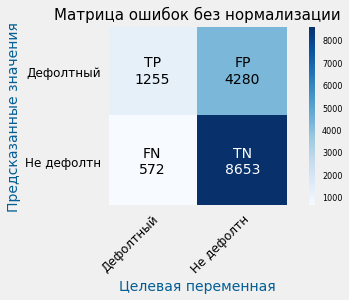

In [129]:
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1.2, normalize=False)

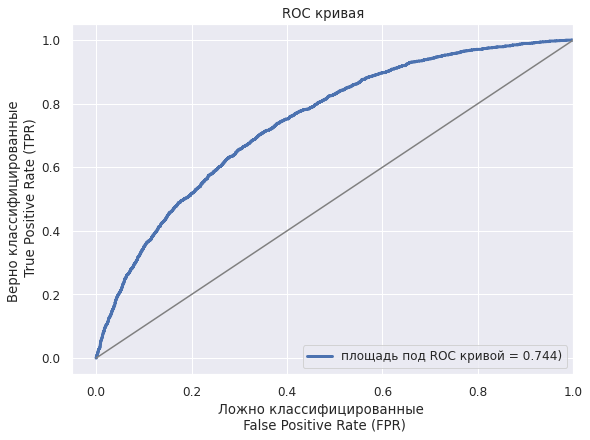

In [130]:
ROC_curve_with_area(y_test, y_pred_prob, 1.1)

# !!!!!!!!!!!!!!!!!   
Пока лучший результат 0.745 на этих настройках:  
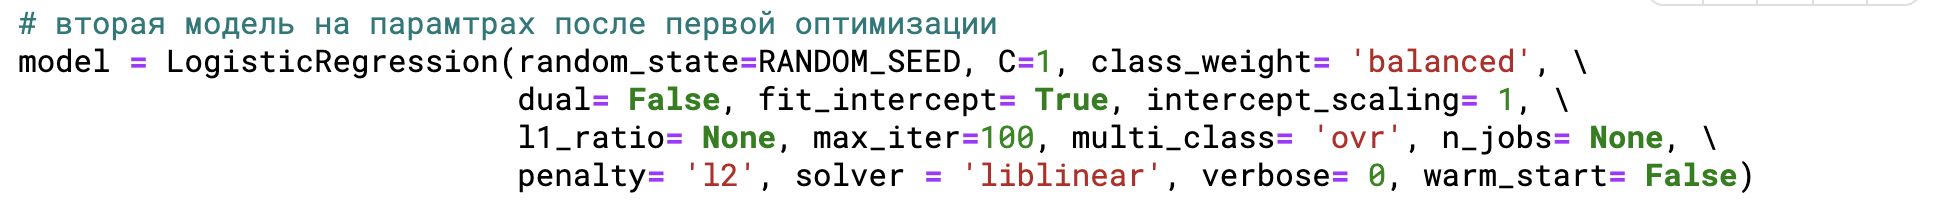

# ГИПОТЕЗА:   УДАЛИТЬ ПОСЛЕ ОТЛАДКИ
Устранение из обучения признака client_id из списка числовых переменных позволит повысить точность модели, ведь этот признак - просто id клиента.   
Так же устранить выбросы в сичловых признаках.

## Кросс-валидация 

In [131]:
model.fit(X_train, y_train)

cross_val_score(model, X_test, y_test, cv=10, scoring='roc_auc')

array([0.75141821, 0.75404233, 0.72551251, 0.73235032, 0.7333308 ,
       0.71445657, 0.74304261, 0.74365541, 0.73784861, 0.76517947])

In [132]:
(cross_val_score(model, X_test, y_test, cv=10, scoring='roc_auc')).mean()

0.7400836834969095

При разбиении на 10 фолдов ROC-AUC меняется не сильно, нет провалов.  
Среднее по фолдам примерно равно предсказанному значению до кроссвалидации

Проверка нулевых коэффициэнтов при регуляризации первого порядка

In [133]:
pd.set_option('display.max_rows', 100) # больше строк

# посмотрим на коэф модели
# слишком маленькие коэффициенты говорят либо необходимости удалить признак либо наличии выбросов 
temp_dict = {}
temp_dict['имя признака'] = train_x_cols
temp_dict['коэффициент модели'] = model.coef_[0]
temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
display(temp_df.T)

,имя признака,коэффициент модели
0,sex,0.283561
1,age,0.297785
2,car,-0.0128083
3,car_type,-0.277864
4,decline_app_cnt_x,1.29472
5,good_work,-0.198112
6,score_bki_x,1.07448
7,bki_request_cnt,1.12481
8,income,-0.789465
9,foreign_passport,-0.225284


In [134]:
# Сделаем предсказания и сохраним в csv-файл
y_pred_proba = model.predict_proba(test_x)[:, 1]

submission = df_test[['client_id']]
submission['default'] = y_pred_proba

submission.to_csv('submission2.csv', index=False)
submission.head(10)

,client_id,default
0,74835,0.222148
1,17527,0.794140
2,75683,0.330830
3,26883,0.394534
4,28862,0.156170
5,99881,0.572668
6,26630,0.793765
7,79934,0.198231
8,16605,0.132067
9,105449,0.130333


Результат на лидерборде: roc_auc=0.73778  

Еще не выполнено: удаление выбросов.